In [1]:
import torch
import numpy as np
from torch import nn
import os
import csv
from heapq import heappush, heappop
import heapq
import time
from tqdm.auto import tqdm
import gc

In [21]:
class SkipGram(nn.Module):
    def __init__(self, word_count, n_dims, device):
        super(SkipGram, self).__init__()
        self.word_count = word_count
        self.n_dims = n_dims
        self.device = device
        
        self.central_emb = nn.Embedding(word_count, self.n_dims, sparse=False)
        self.context_emb = nn.Embedding(word_count, self.n_dims, sparse=False, )

        self.criterion = nn.BCEWithLogitsLoss()
    def forward(self, central, positive, negative):
        central_emb = self.central_emb(central).squeeze()
        positive_emb = self.context_emb(positive).squeeze()
        negative_emb = self.context_emb(negative)
        
        positive_scalar_prod = torch.sum(torch.mul(central_emb, positive_emb), dim=1)
        positive_loss = self.criterion(positive_scalar_prod, torch.ones(positive_scalar_prod.shape[0]).to(self.device))
        
        negative_scalar_prod = torch.bmm(negative_emb, torch.unsqueeze(central_emb, 2)).squeeze()
        negative_loss = self.criterion(negative_scalar_prod, torch.zeros_like(negative_scalar_prod).to(self.device))
        
        loss = torch.mean(positive_loss + negative_loss)
        
        return loss

class word_embedd:
    def __init__(self, n_dims):
        self.n_dims = n_dims
    def fit(self, doc_block, batch_size = 5, freq=5, window_size = 2, epochs = 10, lr = 0.01, neg_num = 5):
        self.dict = {}
        
        for doc in doc_block:        #Counting of frequency of words
            for word in doc:
                if word not in self.dict:
                    self.dict[word] = 1
                else:
                    self.dict[word] += 1
                    
        small_words = []
        for word, curr_freq in self.dict.items():  #Words goes to dataset if it was met > freq times
            if curr_freq < freq:
                small_words.append(word)
        for word in small_words:
            del self.dict[word]
        del small_words
        
        word_count = len(self.dict.items())
            
        self.word2idx = {w: idx for (idx, w) in enumerate(self.dict.keys())}
        self.idx2word = {idx: w for (idx, w) in enumerate(self.dict.keys())}
        
        central_data = []
        positive_data = []
        negative_data = []
        print("Creating train data")
        for doc in tqdm(doc_block):     #creating trainig dataset
            doc_len = len(doc)
            for i, word in enumerate(doc):
                if not word in self.dict:
                    continue
                curr_word = self.dict[word]
                #indexes of positive words
                pos_index = [self.word2idx[doc[k]] for k in range(i - window_size, i+window_size+1) \
                                if k!=i and k <= doc_len-1 and k>=0 and doc[k] in self.dict]
                
                for j in range(i - window_size, i+window_size+1):      #Iteration through window
                    pos_index = [self.word2idx[doc[k]] for k in range(i - window_size, i+window_size+1) \
                                if k!=i and k <= doc_len-1 and k>=0 and doc[k] in self.dict]
                    if j != i and j <= doc_len-1 and j >= 0:
                        if doc[j] not in self.dict:
                            continue
                        
                        #positive words and central should not be included in negative words
                        neg_index = np.random.choice(word_count-1 - len(pos_index), neg_num)
                        neg_index = np.array(list(set(range(word_count)) - {i} - {*pos_index}))[neg_index]
                        central_data.append(self.word2idx[word])
                        positive_data.append(self.word2idx[doc[j]])
                        negative_data.append(neg_index)
        print("data created")
        
        self.central_data = np.array(central_data)
        self.positive_data = np.array(positive_data)
        self.negative_data = np.array(negative_data)
        
        print("Training")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SkipGram(word_count, self.n_dims, device)
        self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        for epo in range(epochs):
            loss_val = 0
            n_batches = int(len(central_data)/batch_size)
            for idx in tqdm(range(n_batches)):
                if idx < n_batches:
                    central_words = central_data[idx*batch_size:(idx+1)*batch_size]
                    positive_words = positive_data[idx*batch_size:(idx+1)*batch_size]
                    negative_words = negative_data[idx*batch_size:(idx+1)*batch_size]
                else:
                    central_words = central_data[idx*batch_size:]
                    positive_words = positive_data[idx*batch_size:]
                    negative_words = negative_data[idx*batch_size:]
                
                central = torch.autograd.Variable(torch.LongTensor([central_words])).to(device)
                positive = torch.autograd.Variable(torch.LongTensor([positive_words])).to(device)
                negative = torch.autograd.Variable(torch.LongTensor(negative_words)).to(device)

                optimizer.zero_grad()
                loss = self.model.forward(central, positive, negative)
                loss_val += loss.item()
                loss.backward()
                optimizer.step()
                
                gc.collect()
                torch.cuda.empty_cache()
                
            print(f'Loss at epo {epo}: {loss_val/len(central_data)}')
        for key in self.dict:
            self.dict[key] = self.model.central_emb(torch.LongTensor([self.word2idx[key]]).to(device))\
                .detach().cpu().numpy()
            
    def remake_dict(self):
        for key in self.dict:
            self.dict[key] = self.model.central_emb(torch.LongTensor([self.word2idx[key]]).to(device))\
                .detach().cpu().numpy()
            
    def get_words(self):
        return [item[0] for item in self.dict.items()]
    
    def get_emb(self, word):
        try:
            return self.dict[word]
        except:
            raise ValueError("word not in vocab")
            
    def save_model(self, dict_path=os.path.join(os.getcwd(), 'dict.npy')):
        np.save(dict_path, self.dict)
        
    def load_model(self, dict_path=os.path.join(os.getcwd(), 'dict.npy')):
        self.dict = np.load(dict_path, allow_pickle=True)[()]
        
    def get_similiar(self, word, k):
        word_emb = self.get_emb(word)
        heap = []
        for key in self.dict:
            if key == word:
                continue
            key_emb = self.dict[key]
            distance = np.linalg.norm(word_emb - key_emb)
            if len(heap) < k:
                heapq.heappush(heap, (distance, key))
            else:
                heapq.heappushpop(heap, (distance,key))
        for item in heap:
            print(item)
            

In [22]:
corpus = [['he', 'is', 'a', 'king'],
         ['she', 'is', 'a', 'queen'],
         ['he', 'is', 'a', 'man'],
         ['she', 'is', 'a', 'woman'],
         ['warsaw', 'is', 'poland', 'capital'],
         ['berlin', 'is', 'germany', 'capital'],
         ['paris', 'is', 'france', 'capital']]
embed = word_embedd(5)
embed.fit(corpus, freq = 1, window_size=2)

Creating train data



data created
Training



Loss at epo 0: 0.3753985779626029



Loss at epo 1: 0.3385240273816245



Loss at epo 2: 0.3099922009876796



Loss at epo 3: 0.2860196122101375



Loss at epo 4: 0.26586498958723886



Loss at epo 5: 0.24890112110546658



Loss at epo 6: 0.2345648101397923



Loss at epo 7: 0.22236879127366202



Loss at epo 8: 0.21191324506487166



Loss at epo 9: 0.20288354967321667


In [23]:
embed.get_words()

['he',
 'is',
 'a',
 'king',
 'she',
 'queen',
 'man',
 'woman',
 'warsaw',
 'poland',
 'capital',
 'berlin',
 'germany',
 'paris',
 'france']

In [24]:
embed.get_similiar('man', 4)

(3.0153747, 'poland')
(3.182309, 'france')
(3.5303564, 'germany')
(3.2670796, 'warsaw')


In [25]:
embed.get_emb('he')

array([[-0.34441337, -0.521349  ,  0.8406787 ,  0.05467339, -1.0133648 ]],
      dtype=float32)

In [26]:
embed.save_model()

In [27]:
embed1 = word_embedd(5)
embed1.load_model()

In [28]:
embed1.get_emb('he')

array([[-0.34441337, -0.521349  ,  0.8406787 ,  0.05467339, -1.0133648 ]],
      dtype=float32)

In [7]:
from sklearn.datasets import fetch_20newsgroups
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [8]:
train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names, " - 20 возможных тем")

dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']  - 20 возможных тем


In [9]:
def normalize(raw_text):
    raw_text = raw_text.lower().replace('\n', ' ') #lowering and remove \n symbols
    preprocessed_text = re.sub(r'\d+', '', raw_text) #removing digits

    
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    preprocessed_text = regex.sub('', preprocessed_text)       #removing punctuation
    
    preprocessed_text = preprocessed_text.strip() #remove whitespaces
    preprocessed_text = [word for word in preprocessed_text.split(' ') if len(word)]
    
    #стоит использовать остальные пункты для препроцессинга текста. Как удаление стопслов, слов не имеющих смысла.
    
    stop_words = set(stopwords.words('english'))
    preprocessed_text = [word for word in preprocessed_text if not word in stop_words]
    
    #оставить от слов только их начальные формы
    stemmer= PorterStemmer()
    preprocessed_text = [stemmer.stem(word) for word in preprocessed_text]
    lemmatizer=WordNetLemmatizer()
    preprocessed_text = [lemmatizer.lemmatize(word) for word in preprocessed_text]
    
    #Также стоит выбросить некоторые части речи:
    not_suitable_pos = ['CC', 'PRP', 'MD', 'DT']
    #"союзы", местоимения, модальные глаголы, детерминанта соответственно
    
    preprocessed_text = [pair[0] for pair in nltk.pos_tag(preprocessed_text) 
                         if pair[1] not in not_suitable_pos]
    
    return preprocessed_text

data_normalized = [normalize(news) for news in tqdm(dataset.data)]

In [10]:
model = word_embedd(100)

In [11]:
start_time = time.time()
model.fit(data_normalized, epochs=10, neg_num=5, batch_size=1000, freq=15, lr=0.01)
print("--- %s seconds ---" % (time.time() - start_time))

Creating train data



data created
Traing



Loss at epo 0: 0.004397649041835962



Loss at epo 1: 0.0015244048028806654



Loss at epo 2: 0.0010302333831073642



Loss at epo 3: 0.0008751512733781838



Loss at epo 4: 0.0008083474758025361



Loss at epo 5: 0.0007696509771424156



Loss at epo 6: 0.0007427564856127705



Loss at epo 7: 0.0007225848222699865



Loss at epo 8: 0.0007064584230391924



Loss at epo 9: 0.0006937299211866838
--- 1244.5822949409485 seconds ---


In [12]:
model.get_similiar('help', 10)

(11.562458, 'lamb')
(11.598226, 'fidonet')
(11.60642, 'hed')
(11.863464, 'link')
(11.629761, 'nba')
(11.89376, 'derek')
(12.630979, 'matya')
(11.992172, 'jekcunihgov')
(12.031839, 'allen')
(11.647069, 'thumb')


In [13]:
#Data for t-sne visualization

labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model.get_emb(x))
        labels.append(x)
    except ValueError:
        continue
embeddings = np.array(embeddings).squeeze()

In [14]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

In [15]:
def embeddings_2d(embeddings):
    return TSNE(n_components=2).fit_transform(embeddings)
low_dim_vectors = embeddings_2d(embeddings)

d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


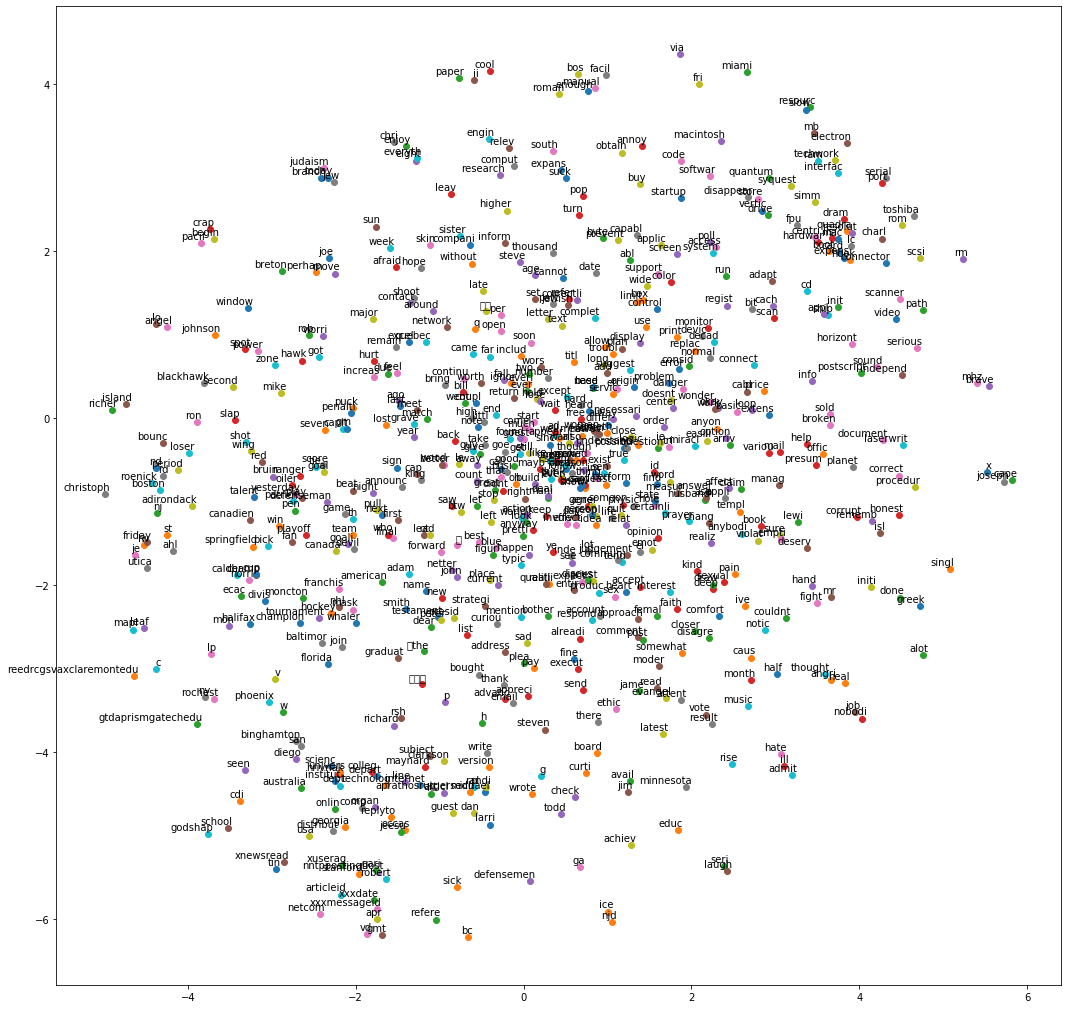

In [16]:
num_words_to_draw = len(labels)
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)